Install the necessary modules by uncommenting the below block

In [23]:
# !pip install rasterio
# !pip install geopandas

In [1]:
# !pip install geemap
# !pip install geetools

import ee
import geemap
import pprint
import folium
import geetools

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Enter verification code:  4/1AfJohXkWTIpwWKd7xa0vPWOUKNHcEPfuzr6WF9v5TsqmzoFKFQgH3Z9qsHY



Successfully saved authorization token.


In [2]:
import os 
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
from osgeo import gdal
import requests
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show,reshape_as_raster, reshape_as_image
from itertools import product
import rasterio as rio
from sklearn.preprocessing import StandardScaler
from rasterio import windows,mask
from rasterstats import zonal_stats
import glob
from rasterio.merge import merge
os.chdir('/home/jovyan/MSC_Thesis/MSc_Thesis_2023')

#Download Cropland Data Layer for Soybean

In [3]:
pp = pprint.PrettyPrinter(depth=4)
dataset = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2017-01-01', '2022-11-01')).select('cropland')
us_states = ee.FeatureCollection("TIGER/2018/States")
lis = ee.List(['Illinois', 'Iowa','Minnesota','Nebraska','Indiana']);
# lis = ee.List(['Minnesota']);
# lis = ee.List(['Illinois']);


lith_ds = ee.Image('CSP/ERGo/1_0/US/lithology');


selected_states = us_states.filter(ee.Filter.inList('NAME', lis));

def getSoybean(image):
  # 5 - Soybean
  return image.eq([5]).clip(selected_states)
  # return image.clip(selected_states)

def getDEM(image):
    return image.clip(selected_states)

# def getLith(image):
#     return image.clip(selected_states)
    

soybean_cdl = dataset.map(getSoybean)

In [40]:
# soybean_cdl

In [4]:
states_geometry = selected_states.geometry()
# states_geometry

In [5]:
# Create a default map
Map = geemap.Map()

# Load an image.
image = soybean_cdl.limit(1, 'system:time_start', False)

dem = ee.Image('USGS/3DEP/10m')
min_ele = 0
max_ele = 3000
elevation = dem.select('elevation').unitScale(min_ele,max_ele).clip(selected_states)

# print(elevation.reduceRegion(reducer= ee.Reducer.min()),geometry=ee.Geometry.BBox())
lithology = lith_ds.select('b1').clip(selected_states)

# Download Sentinel-2 imagery

In [6]:
import matplotlib.pyplot as plt

In [7]:
# /**
#  * Function to mask clouds using the Sentinel-2 QA band
#  * @param {ee.Image} image Sentinel-2 image
#  * @return {ee.Image} cloud masked Sentinel-2 image
#  */
def maskS2clouds(image):
    qa = image.select('QA60');

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000);


In [8]:
def getSentinel(image):
    return image.clip(selected_states)

selected_states = us_states.filter(ee.Filter.inList('NAME', lis));

def getSoybean(image):
  # 5 - Soybean
  return image.eq([5]).clip(selected_states)
  # return image.clip(selected_states)
# Applies scaling factors.
def apply_scale_factors(image):
    # optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # thermal_bands = image.select('ST_B.*').multiply(0.00341802)
    thermal_bands = image.unitScale(0,65535)
    return image.addBands(thermal_bands, None, True)
    

In [9]:
# Get the number of images.
count = soybean_cdl.size()
print('Count of soybean layers: ', str(count.getInfo())+'\n')

# // Map the function over a month of data and take the median.
# // Load Sentinel-2 TOA reflectance data (adjusted for processing changes
# // that occurred after 2022-01-25).

# // Pre-filter to get less cloudy granules.
# COPERNICUS/S2_SR_HARMONIZED ## Try first, if not try COPERNICUS/S2_HARMONIZED

years = [2016,2017,2018,2019,2020,2021,2022]
cnt = 0
merged_dataset = list()


for i in years:
    if i <= 2018:
        sent_ds = 'COPERNICUS/S2_HARMONIZED'
    else:
        sent_ds = 'COPERNICUS/S2_SR_HARMONIZED'
    sentinel_dataset_yearly = ee.ImageCollection(sent_ds).filterDate(str(i)+'-07-1', str(i)+'-07-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)).map(maskS2clouds).select('B.*').map(getSentinel).mean();
    soybean_yearly = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date(str(i)+'-01-01', str(i)+'-12-31')).select('cropland').map(getSoybean).toBands()
    # soil_moisture_ds = ee.ImageCollection('NASA/SMAP/SPL4SMGP/007').filter(ee.Filter.date(str(i)+'-07-01', str(i)+'-07-31')).select('sm_surface','sm_rootzone','sm_profile','sm_surface_wetness','sm_rootzone_wetness','sm_profile_wetness').map(getSentinel).mean()
    lst_landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(str(i)+'-07-1', str(i)+'-07-31').select('ST_B10').map(apply_scale_factors).map(getSentinel).mean()
    # elevation_yearly = elevation.filter(ee.Filter.date(str(i)+'-01-01', str(i)+'-12-31'))
    # lithology_yearly = lithology.filter(ee.Filter.date(str(i)+'-01-01', str(i)+'-12-31'))
    soybean_yrly = soybean_yearly.rename(['cropland_'+str(i)])
    merged_dataset_yearly = sentinel_dataset_yearly.addBands(soybean_yrly)
    merged_dataset_yearly = merged_dataset_yearly.addBands(elevation)  
    merged_dataset_yearly = merged_dataset_yearly.addBands(lst_landsat)
    # merged_dataset_yearly = merged_dataset_yearly.addBands(lithology)
    merged_dataset.append(merged_dataset_yearly)
    cnt+=1

Count of soybean layers:  6



In [11]:
grids.shape

(5912, 9)

In [12]:
5912*7

41384

In [10]:
grids = gpd.read_file('Input/Target/concat/grid_geometries.shp')

In [14]:
count = 0
for i in range(grids.shape[0]):
    # count+=1
   
        
    geomtest = grids.iloc[i].geometry
    geom_bbox = ee.Geometry.BBox(*geomtest.bounds)
    for j in range(len(merged_dataset)):
        count+=1
        sep = "_"
        patch_name = grids.iloc[i]["patch_name"].split(sep)
        file_name = sep.join([patch_name[0],str(years[j]),patch_name[2],patch_name[3]])
        # print(file_name)
        existing_file = glob.glob('Input/data_dec_1_2023/patches/'+file_name+'.tif')
        if len(existing_file) == 1:
            continue            
        
        clipTest = merged_dataset[j].clip(geom_bbox)
        url = clipTest.getDownloadURL({'scale':19.5,
                                'format': 'GEO_TIFF'})
        response = requests.get(url)
        with open('Input/data_dec_1_2023/patches/'+file_name+'.tif', 'wb') as fd:
            # print(file_name)
            fd.write(response.content)

print("Done! Count = ",count)

Done! Count =  41384


In [3]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import reshape_as_image,reshape_as_raster,show

file = 'Input/data_dec_1_2023/patches/Iowa_2022_july_7680-3072.tif'
img = rio.open(file)
img_arr = reshape_as_image(img.read())
img_arr.shape

img.close()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [49]:
years = [2016,2017,2018]
i = "2018"
int(i) in years

True

In [4]:
file2 = 'Input/data_dec_1_2023/patches/Minnesota_2018_july_2304-5376.tif'
img2 = rio.open(file2)
img2_arr = reshape_as_image(img2.read())
img2_arr.shape

img2.close()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


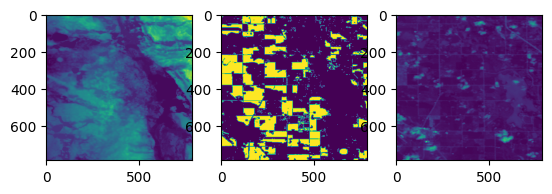

In [50]:
plt.subplot(1,3,1)
plt.imshow(img2_arr[:,:,14])

plt.subplot(1,3,2)
plt.imshow(img2_arr[:,:,13])

plt.subplot(1,3,3)
plt.imshow(img2_arr[:,:,0])


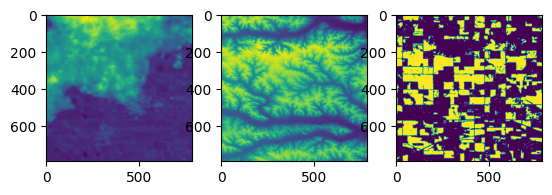

In [12]:
plt.subplot(1,3,1)
plt.imshow(img_arr[:,:,14])

plt.subplot(1,3,2)
plt.imshow(img_arr[:,:,13])

plt.subplot(1,3,3)
plt.imshow(img_arr[:,:,12])

In [77]:
mask = img_arr[:,:,12]
mask = mask[:,:,np.newaxis]
output = mask*img_arr[:,:,0:12]
output.shape

(789, 789, 12)

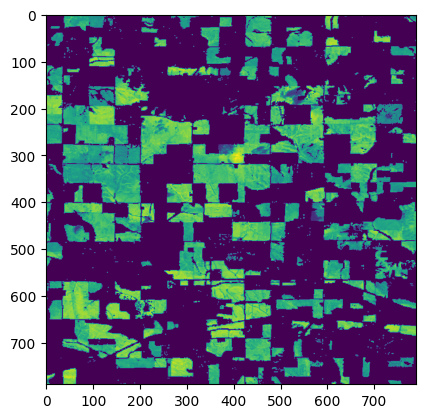

In [82]:
plt.imshow(output[:,:,6])

In [22]:
import numpy as np

In [36]:
img1 = img_arr[:,:,0:12]
img2 = img_arr[:,:,13:15]

img = np.dstack((img1,img2))
print(img.shape)

(789, 789, 14)


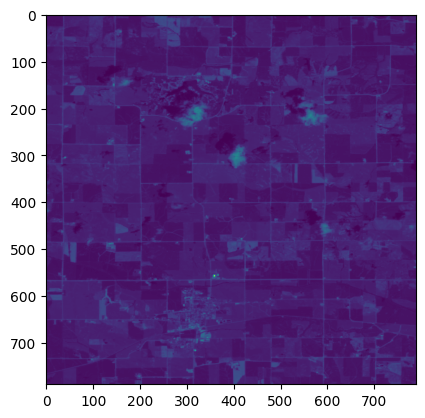

In [34]:
plt.imshow(img1[:,:,11])

In [24]:
img_arr.shape

(789, 789, 15)

In [52]:
img2_arr.shape

(788, 789, 16)

In [63]:
import cv2
res = cv2.resize(img2_arr, dsize=(789, 789), interpolation=cv2.INTER_LINEAR)

In [65]:
print(res.max())
print(img2_arr.max())

1.0
1.0


(789, 789, 16)


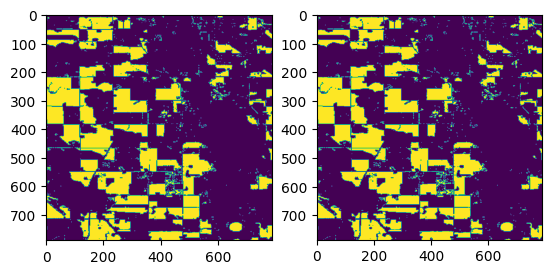

In [66]:
print(res.shape)

band = 13
plt.subplot(1,2,1)
plt.imshow(res[:,:,band])

plt.subplot(1,2,2)
plt.imshow(img2_arr[:,:,band])

In [12]:
import rasterio as rio

try:
    f1 = rio.open('Input/data_dec_1_2023/patches/Illinois_2017_july_1280-4096.tif')
except Exception as ee:
    print(ee)

'Input/data_dec_1_2023/patches/Illinois_2017_july_1280-4096.tif' not recognized as a supported file format.
